In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('..')
from idlmam_custom import *

assert(torch.cuda.is_available())
device = torch.device("cuda")

<Axes: >

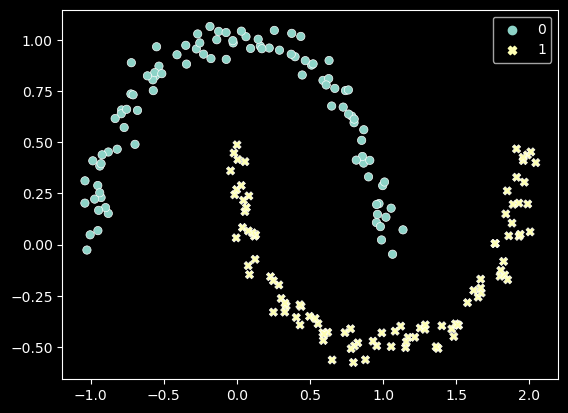

In [2]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.05)
sns.scatterplot(x=X[:,0], y=X[:,1], hue=y, style=y)

We need to be consistent with the chosen device.

In [3]:
from sklearn.metrics import accuracy_score, f1_score
X_train, y_train = make_moons(n_samples=8000, noise=0.2)
X_test, y_test = make_moons(n_samples=200, noise=0.2)

train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.long)
)
test_dataset = TensorDataset(
    torch.tensor(X_test, dtype=torch.float32),
    torch.tensor(y_test, dtype=torch.long)
)
training_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
testing_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, pin_memory=True)

model = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2),
).to(device)

optimizer = torch.optim.AdamW(model.parameters())
f_loss = nn.CrossEntropyLoss()

In [4]:
results_pd = train_network(model, f_loss, training_loader, test_loader=testing_loader, optimizer = optimizer, 
                           epochs=5, device=device, score_funcs={'Acc': accuracy_score, 'F1': f1_score},
                           checkpoint_file='model.pt', disable_tqdm=False )
results_pd

Epoch: 100%|██████████| 5/5 [00:02<00:00,  2.42it/s]


,epoch,total time,train loss,test loss,train Acc,test Acc,train F1,test F1
0,0,0.464195,0.343727,0.268101,0.847500,0.880,0.850012,0.884615
1,1,0.895201,0.265570,0.258937,0.887750,0.890,0.887778,0.893204
2,2,1.254208,0.226940,0.202160,0.910125,0.920,0.910450,0.920792
3,3,1.612157,0.169761,0.153856,0.936375,0.935,0.936431,0.934673
4,4,1.980640,0.124706,0.141965,0.957250,0.940,0.957325,0.940594


<Axes: xlabel='total time', ylabel='train Acc'>

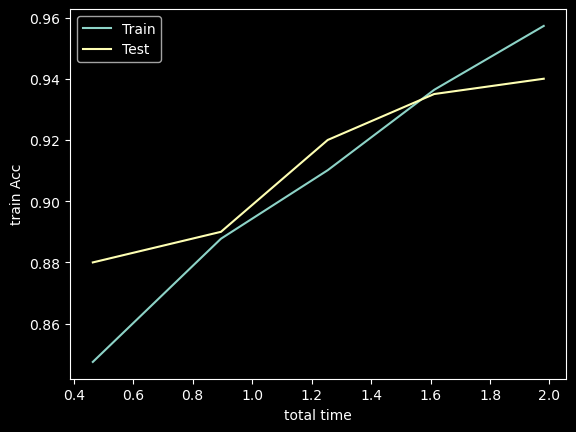

In [5]:
sns.lineplot(x='total time', y='train Acc', data=results_pd, label='Train')
sns.lineplot(x='total time', y='test Acc', data=results_pd, label='Test')

In [6]:
model_new = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2),
).to(device)

#if we want to continue training with a new instance of the model, we need a new
#optimizer targeting the parameters of that new model instance. also, ESSENTIAL:
# https://stackoverflow.com/questions/66091226/runtimeerror-expected-all-tensors-to-be-on-the-same-device-but-found-at-least
# https://discuss.pytorch.org/t/code-that-loads-sgd-fails-to-load-adam-state-to-gpu/61783/5?u=shaibagon
optimizer_new = torch.optim.AdamW(model_new.parameters())

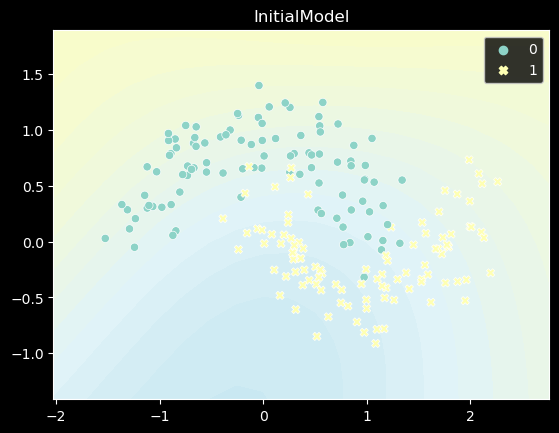

In [7]:
visualize2DSoftmax(X_test, y_test, model_new, title="InitialModel")

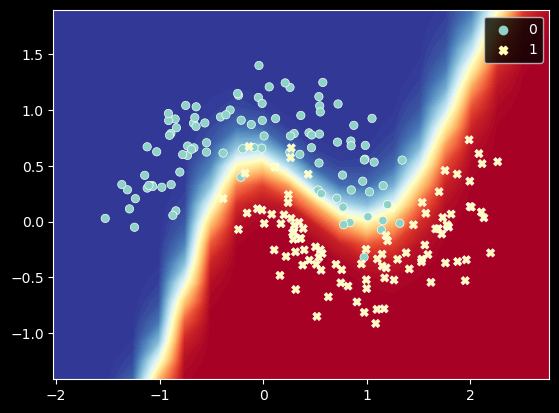

In [8]:
checkpoint_dict = torch.load('model.pt', map_location=device)

model_new.load_state_dict(checkpoint_dict['model_state_dict'])
optimizer_new.load_state_dict(checkpoint_dict['optimizer_state_dict'])

visualize2DSoftmax(X_test, y_test, model_new)

In [9]:
results_pd = train_network(model_new, f_loss, training_loader, test_loader=testing_loader, optimizer = optimizer_new, 
                           epochs=10, device=device, score_funcs={'Acc': accuracy_score, 'F1': f1_score},
                           checkpoint_file='model_new.pt' )
results_pd

Epoch: 100%|██████████| 10/10 [00:04<00:00,  2.25it/s]


,epoch,total time,train loss,test loss,train Acc,test Acc,train F1,test F1
0,0,0.420107,0.105085,0.122734,0.962375,0.950,0.962380,0.949495
1,1,0.818130,0.096703,0.131708,0.964125,0.930,0.964174,0.932039
2,2,1.228703,0.091267,0.109087,0.965125,0.935,0.965182,0.935961
3,3,1.635192,0.089661,0.104961,0.966250,0.940,0.966309,0.940000
4,4,2.045604,0.089423,0.098343,0.966625,0.950,0.966621,0.950000
5,5,2.445196,0.087887,0.099764,0.964875,0.950,0.964932,0.949495
6,6,2.847731,0.087080,0.095724,0.966000,0.950,0.966051,0.950000
7,7,3.379138,0.088062,0.117866,0.966625,0.950,0.966679,0.950000
8,8,3.827925,0.087097,0.107264,0.966500,0.955,0.966550,0.954315
9,9,4.274016,0.087090,0.100861,0.966625,0.955,0.966663,0.954774


<Axes: xlabel='total time', ylabel='train Acc'>

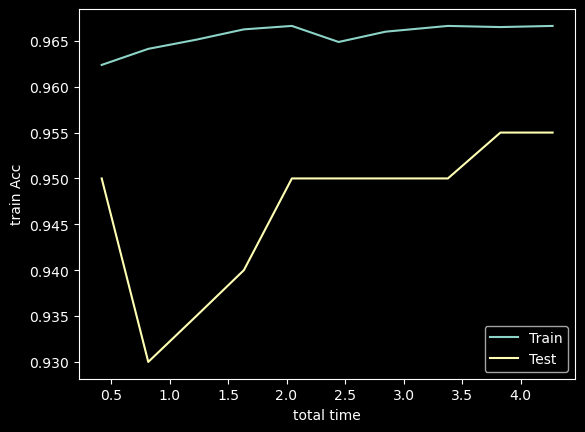

In [10]:
sns.lineplot(x='total time', y='train Acc', data=results_pd, label='Train')
sns.lineplot(x='total time', y='test Acc', data=results_pd, label='Test')